Shapes: (20, 5) (20,)
Updated shapes: X=(22, 5), y=(22,)
y range: -2.5712 → -0.5418, mean=-1.4107


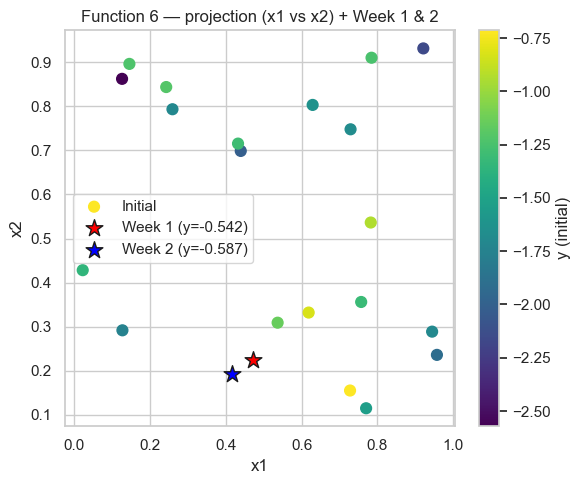

Bounds usados:
 lb: [0.       0.032657 0.       0.       0.      ] 
 ub: [1.         1.         1.         1.         0.98203071]


In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel
from scipy.stats import qmc, norm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
# --- Paths y carga ---
BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR / "initial_data" / "function_6"   # <- ajusta si tu carpeta usa otro nombre
X = np.load(DATA_DIR / "initial_inputs.npy")          # (20,5)
y = np.load(DATA_DIR / "initial_outputs.npy")         # (20,)

X = np.asarray(X, float); y = np.asarray(y, float).ravel()
n, d = X.shape
print("Shapes:", X.shape, y.shape)

# === Semana 1  ===
X_prev, y_prev = X.copy(), y.copy()

w1_input  = np.array([0.471095, 0.223517, 0.632662, 0.959010, 0.000704], dtype=float)
w1_output = float(-0.5417837702081443)

w2_input  = np.array([0.41723 , 0.192026, 0.747316, 0.983725, 0.001043], dtype=float)
w2_output = float(-0.5865422839076195)

# === Añadir W1 y W2 (evita duplicados por re-ejecución) ===
def append_if_new(X, y, x_new, y_new, tol=1e-9):
    if np.any(np.all(np.isclose(X, x_new, atol=tol), axis=1)):
        print("  → Punto ya presente, omitido:", x_new)
        return X, y
    X = np.vstack([X, x_new])
    y = np.append(y, y_new)
    return X, y

X, y = append_if_new(X, y, w1_input, w1_output)
X, y = append_if_new(X, y, w2_input, w2_output)

print(f"Updated shapes: X={X.shape}, y={y.shape}")
print(f"y range: {y.min():.4f} → {y.max():.4f}, mean={y.mean():.4f}")
# --- Proyección rápida x1-x2 con W1 y W2 marcados ---
plt.figure(figsize=(6,5))
sc = plt.scatter(X_prev[:,0], X_prev[:,1], c=y_prev, cmap="viridis", s=60, label="Initial")
plt.colorbar(sc, label="y (initial)")
plt.scatter(w1_input[0], w1_input[1], c="red", s=160, marker="*", edgecolors="k",
            label=f"Week 1 (y={w1_output:.3f})")
plt.scatter(w2_input[0], w2_input[1], c="blue", s=160, marker="*", edgecolors="k",
            label=f"Week 2 (y={w2_output:.3f})")
plt.xlabel("x1"); plt.ylabel("x2")
plt.title("Function 6 — projection (x1 vs x2) + Week 1 & 2")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

# --- Bounds desde datos + 10% de acolchado y clamp a [0,1] ---
lo, hi = X.min(axis=0), X.max(axis=0)
pad = 0.10
lb = np.clip(lo - pad*(hi - lo), 0.0, 1.0)
ub = np.clip(hi + pad*(hi - lo), 0.0, 1.0)
print("Bounds usados:\n lb:", lb, "\n ub:", ub)

2) Escalado y surrogate (GP Matern + ruido leve)
	•	normalize_y=True porque venimos de una transformación de minimización→maximización y las escalas pueden ser raras.
	•	Matern(ν=2.5) con ARD (longitudes por dimensión) para capturar correlaciones entre ingredientes.
	•	WhiteKernel pequeño por estabilidad; si notas más ruido, súbelo un poco.

In [3]:
from sklearn.gaussian_process.kernels import ConstantKernel as C
# GP robusto: F6 (negativo, ruido moderado)
# para semana 3: # --- GP (ruido moderado en F6) ---

kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=np.ones(5)*0.4, nu=2.5,
                                      length_scale_bounds=(0.05, 3.0)) \
         + WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-5, 5e-2))
gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True,
                              n_restarts_optimizer=15, random_state=0)
gp.fit(X, y)
print("Kernel F6:", gp.kernel_)

# --- Candidatos: 80% TR (alrededor de W1) + 20% global ---
lo, hi = np.zeros(5), np.ones(5)
L = 0.35
lb_tr = np.clip(w1_input - 0.5*L*(hi-lo), 0, 1)
ub_tr = np.clip(w1_input + 0.5*L*(hi-lo), 0, 1)

def lhs(lb, ub, n, seed):
    U = qmc.LatinHypercube(d=len(lb), seed=seed).random(n)
    return lb + U*(ub - lb)

C_tr = lhs(lb_tr, ub_tr, 24000, seed=6061)
C_gl = lhs(lo,    hi,     6000, seed=6062)
Cands = np.vstack([C_tr, C_gl])

# --- EI con poca exploración ---
mu, sigma = gp.predict(Cands, return_std=True)
sigma = np.maximum(sigma, 1e-12)
y_best = y.max()          # el menos negativo observado
xi = 0.02
imp = mu - y_best - xi
Z = imp / sigma
ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
ei[sigma < 1e-12] = 0.0

# --- Anti-borde / anti-duplicado ---
edge_eps = 1e-3
mask_edges = np.all((Cands > edge_eps) & (Cands < 1 - edge_eps), axis=1)
ei_masked = np.where(mask_edges, ei, -np.inf)

def too_close_Linf(c, X, tol=0.03):
    return np.any(np.max(np.abs(X - c), axis=1) < tol)

order = np.argsort(-ei_masked)
x_next = None
for i in order:
    cand = Cands[i]
    if not too_close_Linf(cand, X, tol=0.03):
        x_next = cand; break

print("Suggested next (F6, W3):", x_next)
print("Submission:")
print(" - ".join(f"{v:.6f}" for v in x_next))

Kernel F6: 1.43**2 * Matern(length_scale=[0.613, 0.975, 1.33, 1.31, 0.894], nu=2.5) + WhiteKernel(noise_level=1e-05)
Suggested next (F6, W3): [0.51963152 0.35678413 0.66036107 0.98127034 0.17257422]
Submission:
0.519632 - 0.356784 - 0.660361 - 0.981270 - 0.172574


/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


3) EI (ξ moderado), anti-borde, anti-duplicado y candidato sugerido

4) (Opcional) Visual “scatter” coloreado por EI (proyección x1–x2)

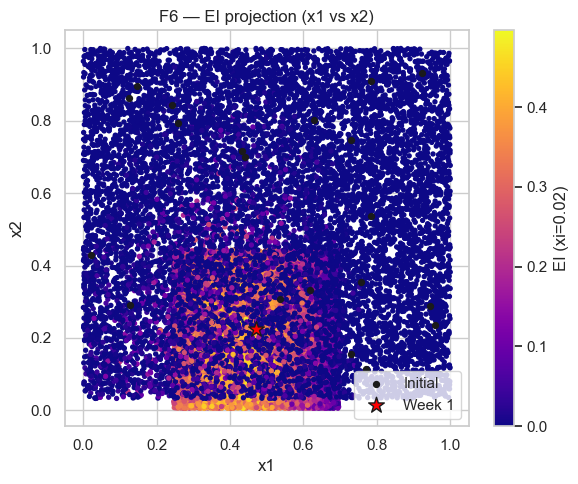

In [4]:
plt.figure(figsize=(6,5))
sc = plt.scatter(Cands[:,0], Cands[:,1], c=ei, cmap="plasma", s=8)
plt.colorbar(sc, label=f"EI (xi={xi})")
plt.scatter(X_prev[:,0], X_prev[:,1], c="k", s=18, label="Initial")
plt.scatter(w1_input[0], w1_input[1], c="red", s=140, marker="*", edgecolors="k", label="Week 1")
plt.xlabel("x1"); plt.ylabel("x2"); plt.title("F6 — EI projection (x1 vs x2)")
plt.legend(loc="best"); plt.tight_layout(); plt.show()

📝 Bitácora (brevísima)
	•	Method: GP (Matern ν=2.5, normalize_y) + EI (ξ=0.02), TR centrada en W1, anti-borde/duplicado.
	•	Focus: Refinamiento local tras mejora en W1 (buscar menos negativo).
	•	Next: Si mejora, bajar ξ→0.01 y estrechar TR; si no, subir ξ→0.03 y abrir TR con 30% global.

F6 — Week 3 submission: 0.519632 - 0.356784 - 0.660361 - 0.981270 - 0.172574

Kernel ajustado:: 
1.43**2 * Matern(length_scale=[0.613, 0.975, 1.33, 1.31, 0.894], ν=2.5)
+ WhiteKernel(noise_level=1e-05)

Lectura rápida
	•	Las length_scales están en rango razonable (≈0.6–1.3): superficie relativamente suave, buena para refinamiento.
	•	Ruido bajo (1e−5): el GP confía en las observaciones; en F6 esto suele ir bien si los outputs son consistentes.
	•	El punto sugerido está cerca de W1 (que fue mejor que W2), pero con ajustes en x1–x2 y una pequeña apertura en x5 → explotación local con algo de variación.

Checks rápidos (opcional)

Mini bitácora (para tu resumen)
	•	Context: W1 mejor que W2 ⇒ W2 fue un retroceso; recentramos en la región de W1.
	•	Model: GP Matern (ν=2.5, ARD) con ruido bajo; longitudes ~[0.6–1.3].
	•	Acquisition: EI (ξ=0.02), TR cerca de W1 + 20% global; anti-borde y anti-duplicado.
	•	Submission: 0.519632 - 0.356784 - 0.660361 - 0.981270 - 0.172574.
	•	Next: si mejora (y sube hacia 0), mantener ξ o bajarlo a 0.015; si no, subir ξ a 0.04 y abrir TR (L≈0.4).